<a href="https://colab.research.google.com/github/ahaanshah/Food_Classification/blob/master/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu

# **Loaded our necessary imports and libraries**

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

### Now we must load our existing pickle files containing our serialised data as x_train, x_validation, y_train, y_validation



In [5]:
x_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))

x_validation = pickle.load(open("X_validation.pickle", "rb"))
y_validation = pickle.load(open("y_validation.pickle", "rb"))

print(y_train.shape, y_validation.shape, x_train.shape, x_validation.shape)

(1787, 17) (469, 17) (1787, 64, 64, 3) (469, 64, 64, 3)


# **Previewing some of our Images**

(1787, 17)


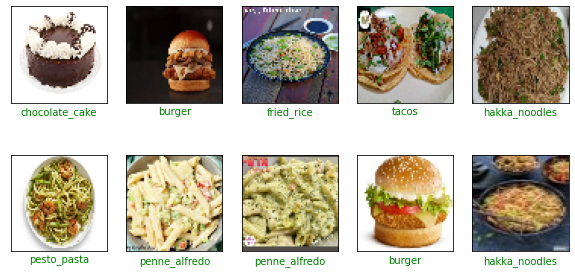

In [7]:
class_names = []
categories = ['burger', 'butter_chicken', 'chocolate_cake', 'dal',
              'donut', 'dosa', 'fish_fry', 'fried_rice',
              'hakka_noodles', 'idli',
              'paratha', 'penne_alfredo', 'pesto_pasta', 'pizza',
              'rajma_chawal', 'tacos', 'waffles']
for i in categories:
    class_names.append(i)

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    print(y.shape)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

## **Data Augmentation**
Since the data set for each class is relatively small to train a good neural network, an image data generator from Keras is used for image tranformation to expand the dataset and to reduce the overfitting problem.

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

# **Convolutional Neural Network Model**
To create a convolution neural network to classfied the images, Keras Sequencial model is used.

In [0]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (64,64,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(17, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])



In [22]:
%%time

h = model.fit(
    x_train/255., y_train,
    validation_data=(x_validation/255., y_validation),
    epochs=100, batch_size=128,
    callbacks=[checkpointer, reduceLR, earlystopping]
)

Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 2.0812 - accuracy: 0.3311
Epoch 00001: val_loss did not improve from 2.21140
14/14 [==============================] - 0s 22ms/step - loss: 2.0818 - accuracy: 0.3313 - val_loss: 2.2179 - val_accuracy: 0.2623 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 2.0297 - accuracy: 0.3425
Epoch 00002: val_loss improved from 2.21140 to 2.05701, saving model to model.hdf5
14/14 [==============================] - 0s 17ms/step - loss: 2.0297 - accuracy: 0.3425 - val_loss: 2.0570 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 3/100
11/14 [======================>.......] - ETA: 0s - loss: 1.9120 - accuracy: 0.3999
Epoch 00003: val_loss improved from 2.05701 to 2.04964, saving model to model.hdf5
14/14 [==============================] - 0s 18ms/step - loss: 1.9280 - accuracy: 0.3895 - val_loss: 2.0496 - val_accuracy: 0.3539 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 

# **Plotting our progress**

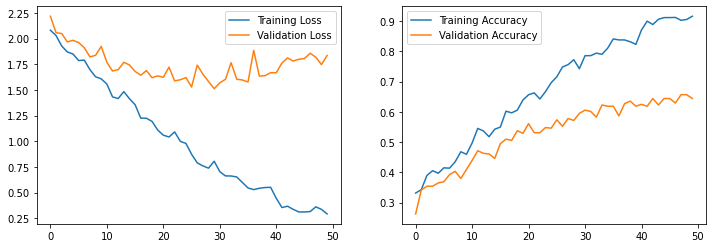

In [23]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()